In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display

In [ ]:
# source of Une Barque sur l'Ocean (piano piece by Maurice Ravel):
# http://ks4.imslp.net/files/imglnks/usimg/c/cc/IMSLP75355-PMLP04225-Maurice_Ravel_-_Une_barque_sur_l'ocean_-_Karstein_Djupdal_2008.mp3

# source of Angry Birds Theme Song:
# https://www.youtube.com/watch?v=DehK_Y0TUbE

# source of Sweet Home Alabama:
# https://youtube.com/watch?v=ye5BuYf8q4o

In [ ]:
# class that uses the librosa library to analyze the key that an mp3 is in
# arguments:
#     waveform: an mp3 file loaded by librosa, ideally separated out from any percussive sources
#     sr: sampling rate of the mp3, which can be obtained when the file is read with librosa
#     tstart and tend: the range in seconds of the file to be analyzed; default to the beginning and end of file if not specified
class Tonal_Fragment(object):
    def __init__(self, waveform, sr, tstart=None, tend=None):
        self.waveform = waveform
        self.sr = sr
        self.tstart = tstart
        self.tend = tend

        if self.tstart is not None:
            self.tstart = librosa.time_to_samples(self.tstart, sr=self.sr)
        if self.tend is not None:
            self.tend = librosa.time_to_samples(self.tend, sr=self.sr)
        self.y_segment = self.waveform[self.tstart:self.tend]
        self.chromograph = librosa.feature.chroma_cqt(y=self.y_segment, sr=self.sr, bins_per_octave=24)

        # chroma_vals is the amount of each pitch class present in this time interval
        self.chroma_vals = []
        for i in range(12):
            self.chroma_vals.append(np.sum(self.chromograph[i]))
        pitches = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
        # dictionary relating pitch names to the associated intensity in the song
        self.keyfreqs = {pitches[i]: self.chroma_vals[i] for i in range(12)}

        keys = [pitches[i] + ' major' for i in range(12)] + [pitches[i] + ' minor' for i in range(12)]

        # use of the Krumhansl-Schmuckler key-finding algorithm, which compares the chroma
        # data above to typical profiles of major and minor keys:
        maj_profile = [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
        min_profile = [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]

        # finds correlations between the amount of each pitch class in the time interval and the above profiles,
        # starting on each of the 12 pitches. then creates dict of the musical keys (major/minor) to the correlation
        self.min_key_corrs = []
        self.maj_key_corrs = []
        for i in range(12):
            key_test = [self.keyfreqs.get(pitches[(i + m)%12]) for m in range(12)]
            # correlation coefficients (strengths of correlation for each key)
            self.maj_key_corrs.append(round(np.corrcoef(maj_profile, key_test)[1,0], 3))
            self.min_key_corrs.append(round(np.corrcoef(min_profile, key_test)[1,0], 3))

        # names of all major and minor keys
        self.key_dict = {**{keys[i]: self.maj_key_corrs[i] for i in range(12)},
                         **{keys[i+12]: self.min_key_corrs[i] for i in range(12)}}

        # this attribute represents the key determined by the algorithm
        self.key = max(self.key_dict, key=self.key_dict.get)
        self.bestcorr = max(self.key_dict.values())

        # this attribute represents the second-best key determined by the algorithm,
        # if the correlation is close to that of the actual key determined
        self.altkey = None
        self.altbestcorr = None

        for key, corr in self.key_dict.items():
            if corr > self.bestcorr*0.9 and corr != self.bestcorr:
                self.altkey = key
                self.altbestcorr = corr

    # prints the relative prominence of each pitch class
    def print_chroma(self):
        self.chroma_max = max(self.chroma_vals)
        for key, chrom in self.keyfreqs.items():
            print(key, '\t', f'{chrom/self.chroma_max:5.3f}')

    # prints the correlation coefficients associated with each major/minor key
    def corr_table(self):
        for key, corr in self.key_dict.items():
            print(key, '\t', f'{corr:6.3f}')

    # printout of the key determined by the algorithm; if another key is close, that key is mentioned
    def print_key(self):
        print("likely key: ", max(self.key_dict, key=self.key_dict.get), ", correlation: ", self.bestcorr, sep='')
        if self.altkey is not None:
                print("also possible: ", self.altkey, ", correlation: ", self.altbestcorr, sep='')

    # prints a chromagram of the file, showing the intensity of each pitch class over time
    def chromagram(self, title=None):
        C = librosa.feature.chroma_cqt(y=self.waveform, sr=sr, bins_per_octave=24)
        plt.figure(figsize=(12,4))
        librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
        if title is None:
            plt.title('Chromagram')
        else:
            plt.title(title)
        plt.colorbar()
        plt.tight_layout()
        plt.show()

In [ ]:
# this audio takes a long time to load because it has a very high sampling rate; be patient.
audio_path = '/content/drive/MyDrive/project25/furfuri-kuma-sagar.mp3'

# the load function generates a tuple consisting of an audio object y and its sampling rate sr
y, sr = librosa.load(audio_path)
# this function filters out the harmonic part of the sound file from the percussive part, allowing for
# more accurate harmonic analysis
y_harmonic, y_percussive = librosa.effects.hpss(y)
ipd.Audio(audio_path)

In [31]:
# this block instantiates the Tonal_Fragment class with the first 22 seconds of the above harmonic part of une barque.
# the three methods called will print the determined key of the song, the correlation coefficients for all keys,
# and a chromogram, which shows the intensity of frequencies associated with each of the 12 pitch classes over time.

furfuri_fsharp_min = Tonal_Fragment(y_harmonic, sr, tend=22)
furfuri_fsharp_min.print_chroma()

C 	 0.127
C# 	 0.330
D 	 0.211
D# 	 0.485
E 	 0.236
F 	 0.672
F# 	 0.312
G 	 0.227
G# 	 0.515
A 	 0.311
A# 	 1.000
B 	 0.363


likely key: A# minor, correlation: 0.739
C major 	 -0.519
C# major 	  0.339
D major 	 -0.485
D# major 	  0.503
E major 	 -0.211
F major 	  0.185
F# major 	  0.279
G major 	 -0.621
G# major 	  0.273
A major 	 -0.401
A# major 	  0.665
B major 	 -0.007
C minor 	 -0.153
C# minor 	 -0.224
D minor 	  0.044
D# minor 	  0.465
E minor 	 -0.564
F minor 	  0.314
F# minor 	 -0.268
G minor 	  0.175
G# minor 	  0.202
A minor 	 -0.403
A# minor 	  0.739
B minor 	 -0.326


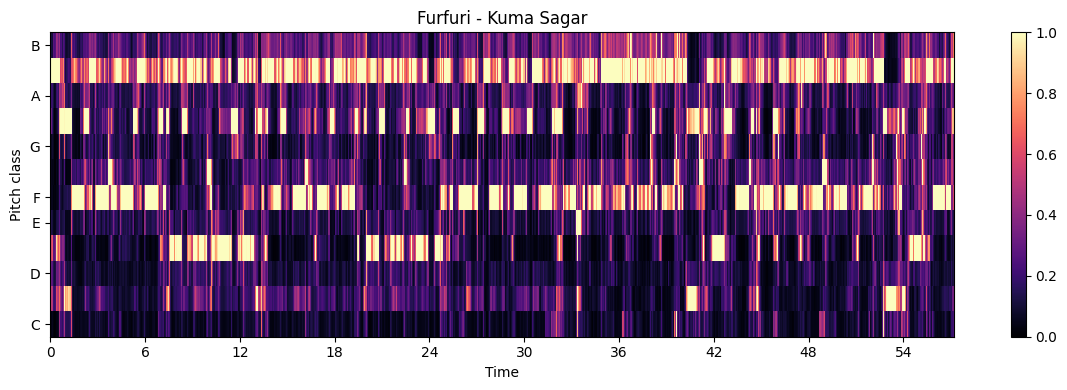

In [32]:
furfuri_fsharp_min.print_key()
furfuri_fsharp_min.corr_table()
furfuri_fsharp_min.chromagram("Furfuri - Kuma Sagar")

In [36]:
# parts of the song that are more tonally ambiguous will show two keys with print_key(),
# if they are similarly well-correlated.
# this section of une barque is in E minor, though the algorithm suggests that it is in D major, a closely related key,
# though E minor is also listed since their correlation coefficients are very close.
furfuri_e_min = Tonal_Fragment(y_harmonic, sr, tstart=22, tend=33)
furfuri_e_min.print_key()
furfuri_e_min.corr_table()

likely key: A# minor, correlation: 0.7
C major 	 -0.459
C# major 	  0.376
D major 	 -0.491
D# major 	  0.413
E major 	 -0.184
F major 	  0.262
F# major 	  0.238
G major 	 -0.624
G# major 	  0.298
A major 	 -0.402
A# major 	  0.605
B major 	 -0.031
C minor 	 -0.172
C# minor 	 -0.222
D minor 	  0.067
D# minor 	  0.357
E minor 	 -0.575
F minor 	  0.440
F# minor 	 -0.242
G minor 	  0.094
G# minor 	  0.222
A minor 	 -0.330
A# minor 	  0.700
B minor 	 -0.339


In [34]:
# in the case of une barque sur l'ocean (and other songs), predictions become less reliable over short time frames
# the below block prints the predicted key of every 3-second-long cut of the piece.
bin_size = 3
for i in range(24):
    fragment = Tonal_Fragment(y_harmonic, sr, tstart = bin_size*i, tend=bin_size*(i+1))
    print(bin_size*i,"sec:",fragment.key)
    if fragment.altkey is not None:
        print("\t or:", fragment.altkey)

0 sec: A# minor
3 sec: A# minor
	 or: A# major
6 sec: A# major
	 or: A# minor
9 sec: D# major
	 or: D# minor
12 sec: A# minor
15 sec: A# minor
18 sec: A# minor
	 or: A# major
21 sec: D# major
	 or: D# minor
24 sec: A# minor
	 or: A# major
27 sec: A# minor
30 sec: A# minor
33 sec: B major
	 or: A# minor
36 sec: A# major
	 or: A# minor
39 sec: F# major
	 or: A# minor
42 sec: D# minor
45 sec: A# major
	 or: A# minor
48 sec: A# minor
51 sec: F# major
54 sec: D# minor
57 sec: B major
	 or: G# minor


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=276
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=138
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=69
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=0
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: Runtim

60 sec: C major
63 sec: C major
66 sec: C major
69 sec: C major


likely key: G major, correlation: 0.803
C major 	  0.359
C# major 	 -0.501
D major 	  0.651
D# major 	  0.117
E major 	 -0.405
F major 	  0.029
F# major 	 -0.521
G major 	  0.803
G# major 	 -0.183
A major 	 -0.028
A# major 	  0.107
B major 	 -0.427
C minor 	  0.326
C# minor 	 -0.437
D minor 	  0.438
D# minor 	 -0.306
E minor 	  0.225
F minor 	 -0.287
F# minor 	 -0.128
G minor 	  0.652
G# minor 	 -0.298
A minor 	  0.074
A# minor 	 -0.562
B minor 	  0.303


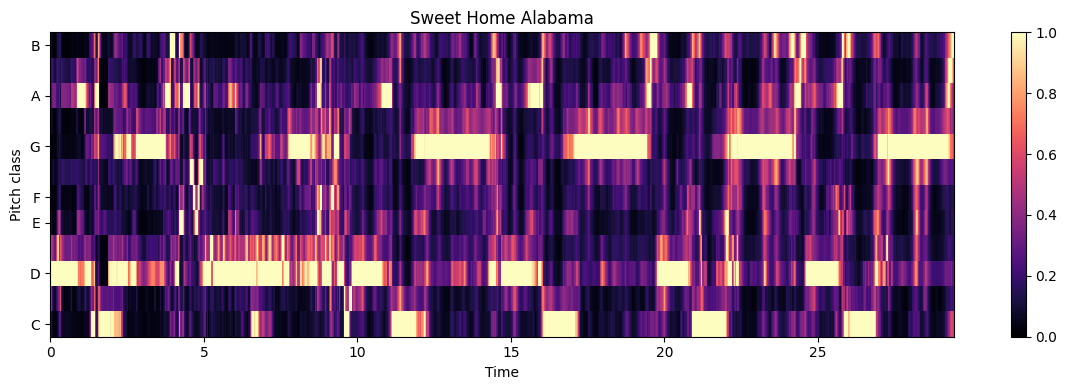

In [ ]:
# lynyrd skynyrd's "sweet home alabama" is a song famously contentious among music theorists due to its ambiguous key;
# it is oft debated whether it is in G major or D major. in this instance, the algorithm chooses G major over D major
# by a wide margin, not even reporting D major as a possible alternative. this is just one example of the human ear's
# impression disagreeing with this simple algorithm.

audio_path = '/content/drive/MyDrive/project25/sweet-home-alabama.mp3'
y, sr = librosa.load(audio_path)
y_harmonic, y_percussive = librosa.effects.hpss(y)

song = Tonal_Fragment(y_harmonic, sr)
song.print_key()
song.corr_table()
song.chromagram("Sweet Home Alabama")

In [ ]:
ipd.Audio(audio_path)

likely key: E minor, correlation: 0.668
C major 	  0.265
C# major 	 -0.518
D major 	 -0.027
D# major 	 -0.273
E major 	  0.493
F major 	 -0.066
F# major 	 -0.185
G major 	  0.325
G# major 	 -0.357
A major 	  0.014
A# major 	 -0.194
B major 	  0.522
C minor 	  0.007
C# minor 	 -0.046
D minor 	 -0.123
D# minor 	 -0.089
E minor 	  0.668
F minor 	 -0.223
F# minor 	 -0.316
G minor 	 -0.270
G# minor 	  0.204
A minor 	  0.140
A# minor 	 -0.442
B minor 	  0.489


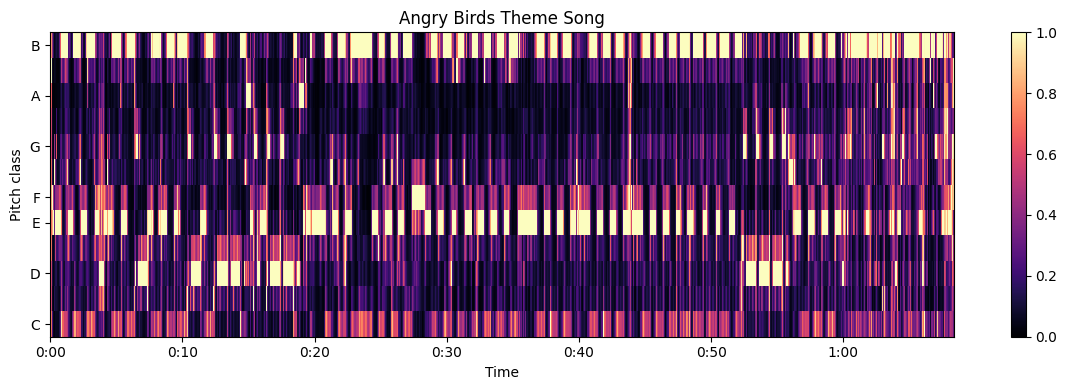

In [ ]:
# the Angry Birds theme song is another song that can be analyzed correctly by the algorithm.
# the whole piece is in E minor, in agreement with the result below.

audio_path = '/content/drive/MyDrive/project25/angry-birds-theme-song.mp3'
y, sr = librosa.load(audio_path)
y_harmonic, y_percussive = librosa.effects.hpss(y)

angry_birds_e_min = Tonal_Fragment(y_harmonic, sr, tstart=0.4)
angry_birds_e_min.print_key()
angry_birds_e_min.corr_table()
angry_birds_e_min.chromagram("Angry Birds Theme Song")

In [ ]:
ipd.Audio(audio_path)